# Character-level RNN for Text Generation

The following project explores the creation of a recurrent neural network that generates text in the style of the provided corpus. For this experiment, the majority of former President Donald Trump's tweets from 2009 to 2021 will be used as training data. Final model output will be evaluated for similar in vocabulary, grammar, and tone to the training material.

### Environment

In [1]:
# general imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import io
import warnings
warnings.filterwarnings("ignore")
import re
import json

# keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, GRU, InputLayer, LSTM, Bidirectional, SimpleRNN
from tensorflow.keras.callbacks import LambdaCallback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# connect to environment
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount = True)
    print("ENVIRONMENT: Google Drive")
except:
    print("ENVIRONMENT: Local")

Mounted at /content/drive
ENVIRONMENT: Google Drive


### Load Data & Preprocess

In [5]:
# read tweet csv
df = pd.read_csv('/content/drive/My Drive/RESEARCH/TEXT_GENERATION/data/trump_twitter_dataset/trump_train.csv')
print(df.shape)
df.head()

(40000, 9)


,id,text,isRetweet,isDeleted,device,favorites,retweets,date,isFlagged
0,1006619872367804400,I strongly endorse Adam Laxalt for Governor of...,f,f,Twitter for iPhone,54668,11776,2018-06-12 19:30:54,f
1,1308870759469777000,Diana Harshbarger (@DHarshbargerTN1) will be a...,f,f,Twitter for iPhone,25880,7268,2020-09-23 20:48:01,f
2,414554545608724500,"""""@SavingNancy: .@realDonaldTrump we raised $6...",f,f,Twitter for Android,76,51,2013-12-22 00:34:40,f
3,456128260741799940,"""""@NickySummer @AlexSalmond Wind farms are an ...",f,f,Twitter Web Client,24,26,2014-04-15 17:53:46,f
4,396359126395007000,"Via @IBTimes: """"Miss Universe 2013: Contestant...",f,f,Twitter Web Client,29,27,2013-11-01 19:32:34,f


In [6]:
# extract tweets & build corpus
corp = ' '.join([x for x in df['text']])
print('BEFORE: ' + corp[:100])

# make lowercase, remove non-alphabetic characters
corp = ' '.join(re.sub('[^a-z]+', ' ', corp.lower()).split())
print('AFTER: ' + corp[:100])

BEFORE: I strongly endorse Adam Laxalt for Governor of Nevada. Adam is smart, works hard, and knows how to w
AFTER: i strongly endorse adam laxalt for governor of nevada adam is smart works hard and knows how to win 


In [7]:
# get all unique characters
print('Corpus Length: ' + str(len(corp)) + ' characters.')
chars = sorted(list(set(corp)))
print('Total Unique Characters: ' + str(len(chars)))

Corpus Length: 4797090 characters.
Total Unique Characters: 27


In [8]:
# create dictionaries that map from char to int / int to char (used to swap between character & one-hot encodings later)
char_i = dict((c, i) for i, c in enumerate(chars))
i_char = dict((i, c) for i, c in enumerate(chars))

In [9]:
# split corpus into sequences
maxlen = 20 # determines the length of character sequences used for training
step = 100 # how many characters to skip between each extracted sequence (to sample full corpus)
seqs = []
next_chars = []

for i in range(0, len(corp) - maxlen, step):
  seqs.append(corp[i: i + maxlen]) # training data
  next_chars.append(corp[i + maxlen]) # target values

print('Total Sequences Generated: ' + str(len(seqs)) + '.')

Total Sequences Generated: 47971.


In [10]:
# One-Hot Encoding
x = np.zeros((len(seqs), maxlen, len(chars)), dtype = np.bool)
y = np.zeros((len(seqs), len(chars)), dtype = np.bool)
for i, seq in enumerate(seqs):
  for t, char in enumerate(seq):
    x[i, t, char_i[char]] = 1
  y[i, char_i[next_chars[i]]] = 1

print(x.shape, y.shape)

(47971, 20, 27) (47971, 27)


### Model

In [11]:
# define architecture
model = Sequential()
model.add(LSTM(24, return_sequences = True, input_shape = (maxlen, len(chars))))
model.add(LSTM(24, return_sequences = True))
model.add(LSTM(24, return_sequences = True))
model.add(LSTM(24))
model.add(Dense(len(chars), activation = 'softmax')) # one output neuron per unique character
model.compile(loss = 'categorical_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20, 24)            4992      
_________________________________________________________________
lstm_1 (LSTM)                (None, 20, 24)            4704      
_________________________________________________________________
lstm_2 (LSTM)                (None, 20, 24)            4704      
_________________________________________________________________
lstm_3 (LSTM)                (None, 24)                4704      
_________________________________________________________________
dense (Dense)                (None, 27)                675       
Total params: 19,779
Trainable params: 19,779
Non-trainable params: 0
_________________________________________________________________


In [12]:
# CALLBACKS

# returns the index of a predicted character (for LambdaCallback)
def sample(preds):
  preds = np.asarray(preds).astype('float64')
  preds = np.log(preds)
  exp_preds = np.exp(preds)
  preds = exp_preds / np.sum(exp_preds)
  probas = np.random.multinomial(1, preds, 1)
  return np.argmax(probas)

# generates text after each epoch (for LambdaCallback)
def on_epoch_end(epoch, logs):
  print()
  print('----- Generating text after Epoch: %d' % epoch)
  seed_length = 20
  start_index = np.random.randint(0, len(corp) - seed_length - 1)
  generated = ''
  segment = corp[start_index: start_index + seed_length]
  generated = generated + segment
  print('----- Generating with seed: "' + segment + '"')
  sys.stdout.write(generated)
  for i in range(140):
    x_pred = np.zeros((1, maxlen, len(chars)))
    for t, char in enumerate(segment):
        x_pred[0, t, char_i[char]] = 1.

    preds = model.predict(x_pred, verbose=0)[0]
    next_index = sample(preds)
    next_char = i_char[next_index]

    generated += next_char
    segment = segment[1:] + next_char

    sys.stdout.write(next_char)
    sys.stdout.flush()

# LambdaCallback will generate text using custom function after each epoch
A = LambdaCallback(on_epoch_end=on_epoch_end)

# ModelCheckpoint callback will save model with the lowest achieved validation loss
B = ModelCheckpoint(filepath = '/content/drive/My Drive/RESEARCH/TEXT_GENERATION/models/rnn_char_model.hdf5', save_best_only = True, verbose = 1)

# EarlyStopping callback will stop training after a certain threshold is reached
C = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 10, min_delta = .001, restore_best_weights=True)

# ReduiceLROnPlateau callback will reduce learning rate given certain criteria to assist with convergence on local minima
D = ReduceLROnPlateau(monitor = 'val_loss', mode = 'min', factor = 0.1, verbose = 1, min_delta = .001, patience = 5)

# package callback functions into variable
cb_list = [A, B, C, D]

In [13]:
history = model.fit(x, y, batch_size = 32, epochs = 100, validation_split = 0.2, verbose = 1, callbacks = cb_list, shuffle = True)

Epoch 1/100
1200/1200 [==============================] - 50s 36ms/step - loss: 2.9025 - accuracy: 0.1789 - val_loss: 2.8874 - val_accuracy: 0.1792

----- Generating text after Epoch: 0
----- Generating with seed: "d for u s amp china "
d for u s amp china h   e ntydd gttg cfot aez s  tp mn n yb z toohuetgg neey rl tt  itlsupdouoxa  tuh eh datatpamwets logsmdt edeng n e irhri v tbbhnyor riii go
Epoch 00001: val_loss improved from inf to 2.88745, saving model to /content/drive/My Drive/RESEARCH/TEXT_GENERATION/models/rnn_char_model.hdf5
Epoch 2/100
1200/1200 [==============================] - 44s 37ms/step - loss: 2.8691 - accuracy: 0.1815 - val_loss: 2.7909 - val_accuracy: 0.1956

----- Generating text after Epoch: 1
----- Generating with seed: "weet me back thanks "
weet me back thanks tetsueut aaatsghngtgja emcitreapmoesiouamlaselmht c wza nci adoam tcaeaaoal rltet ws eef ee sss nktie a ntnpfriivltnartrantts os dvdn ekit e
Epoch 00002: val_loss improved from 2.88745 to 2.79092, saving

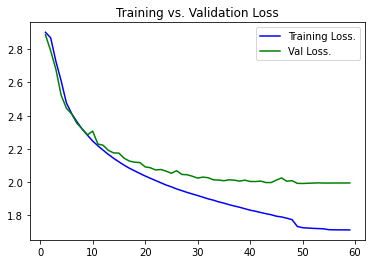

Maximum Validation Accuracy Achieved: 0.4341844618320465


In [15]:
# Plot test/val loss
loss = history.history['loss']
v_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'b', label = 'Training Loss.')
plt.plot(epochs, v_loss, 'g', label = 'Val Loss.')
plt.title ('Training vs. Validation Loss')
plt.legend()
plt.show()

print('Maximum Validation Accuracy Achieved: ' + str(max(history.history['val_accuracy'])))

### Evaluate

In [18]:
# preprocess test data as above
df = pd.read_csv('/content/drive/My Drive/RESEARCH/TEXT_GENERATION/data/trump_twitter_dataset/trump_test.csv')
corp = ' '.join([x for x in df['text']])
corp = ' '.join(re.sub('[^a-z]+', ' ', corp.lower()).split())
char_i = dict((c, i) for i, c in enumerate(chars))
i_char = dict((i, c) for i, c in enumerate(chars))
maxlen = 20
step = 1
seqs = []
next_chars = []
for i in range(0, len(corp) - maxlen, step):
  seqs.append(corp[i: i + maxlen])
  next_chars.append(corp[i + maxlen])
print('Total Test Sequences: ' + str(len(seqs)) + '.')
x_test = np.zeros((len(seqs), maxlen, len(chars)), dtype = np.bool)
y_test = np.zeros((len(seqs), len(chars)), dtype = np.bool)
for i, seq in enumerate(seqs):
  for t, char in enumerate(seq):
    x_test[i, t, char_i[char]] = 1
  y_test[i, char_i[next_chars[i]]] = 1
print(x_test.shape, y_test.shape)

Total Test Sequences: 810960.
(810960, 20, 27) (810960, 27)


In [19]:
# load model
test_model = load_model('/content/drive/My Drive/RESEARCH/TEXT_GENERATION/models/rnn_char_model.hdf5')

In [20]:
test_model.evaluate(x_test, y_test, verbose = 1)

25343/25343 [==============================] - 225s 9ms/step - loss: 1.9928 - accuracy: 0.4312


[1.9928113222122192, 0.4311828017234802]

### Preliminary Findings:
* Test Accuracy: 43.12%
* Sample Sequences Produced:

1. the whole russia hoa s rin as will woy you teusted realdronlaldtrump vatice great ementornyer becahe intidenticn af sprealson cen my bead they utmigateley worde
2. d rather it be here nusp nepefewacry me radestermies gits ghine prosettes hand are tomentitice bualme traw donilg s streol ktmppage that they mikes that the wil
3. caught on camera hiluriny a bevone aresa jratuy is to bucby our to kucl se uve zot how dewems dondew weumy pustner soat tolalitaga firfer the had ands yon eeed

* While final model accuracy was lower than expected, and generated sequences are largely nonsense, it's worth noting the model is able to produce *some* english words using an RNN tokenized with characters (as opposed to words) using only a small, proof-of-concept LSTM network.



### Future Work
* Larger network, potential application of neural architecture search.
* Implement overfitting mitigation (regularization, recurrent dropout, etc).
* More sophisicated data preprocessing (remove urls, twitter handles, etc).
* Transition to word-level tokenization.
* Transition to transformer architecture.

### Acknowledgments
* Trump twitter dataset obtained from [Kaggle](https://https://www.kaggle.com/austinreese/trump-tweets).
* Code inspired by and partially derived from [Vishal Kumar's blog post](https://https://towardsdatascience.com/generating-text-using-a-recurrent-neural-network-1c3bfee27a5e) on a similar topic.